In [3]:
# Mount Google Drive (run this cell first in Colab)
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import os

# =============================================================================
# 1. Load and Prepare the Double-Scaled Dataset (Final 44)
# =============================================================================
file_path = "/content/drive/My Drive/Colab Notebooks/823 Project/Final 44.xlsx"
df = pd.read_excel(file_path)

# Check for required columns
required_columns = ["Return_Next 3M", "Timestamp", "PERMNO"]
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' is missing in the Final 44 database.")

# Drop rows where the target is missing and reset index
df = df.dropna(subset=["Return_Next 3M"]).reset_index(drop=True)

# Ensure Timestamp is an integer (if it isn’t already)
df["Timestamp"] = df["Timestamp"].astype(int)

# (Optional) Print a quick preview and summary statistics
print("Head of the dataset:")
print(df.head())
print("\nSummary statistics:")
print(df.describe())

# Create a binary target for classification: 1 if Return_Next 3M > 0, else 0.
df["target"] = (df["Return_Next 3M"] > 0).astype(int)

# Define non-feature columns; remaining columns will be used as predictors.
non_feature_cols = ["Return_Next 3M", "Timestamp", "PERMNO", "target"]
x_vars = [col for col in df.columns if col not in non_feature_cols]

# =============================================================================
# 2. Define Moving Window Parameters and Split Ranges
# =============================================================================
rolling_window = 36      # Training period (number of unique timestamps)
validation_period = 3    # Validation period
test_period = 2          # Test period

# Get the sorted list of unique timestamps
timestamps = sorted(df["Timestamp"].unique())

# List to store results for each rolling window using Random Forest
results_rf = []

# =============================================================================
# 3. Rolling Window Loop
# =============================================================================
for i in range(len(timestamps) - rolling_window - validation_period - test_period + 1):
    # Define boundaries for training, validation, and test splits
    train_start = timestamps[i]
    train_end = timestamps[i + rolling_window - 1]
    validation_start = timestamps[i + rolling_window]
    validation_end = timestamps[i + rolling_window + validation_period - 1]
    test_start = timestamps[i + rolling_window + validation_period]
    test_end = timestamps[i + rolling_window + validation_period + test_period - 1]

    # Subset the data for each period
    train_data = df[(df["Timestamp"] >= train_start) & (df["Timestamp"] <= train_end)]
    validation_data = df[(df["Timestamp"] >= validation_start) & (df["Timestamp"] <= validation_end)]
    test_data = df[(df["Timestamp"] >= test_start) & (df["Timestamp"] <= test_end)]

    # Debug: Print sample counts for the current window
    print(f"Window ending at Timestamp {train_end}: Train: {len(train_data)}, "
          f"Validation: {len(validation_data)}, Test: {len(test_data)}")

    # Skip window if any split is missing data
    if len(train_data) < rolling_window or len(validation_data) == 0 or len(test_data) == 0:
        print(f"Skipping window ending at {train_end} due to insufficient data.")
        continue

    # Prepare features and target for each split
    X_train = train_data[x_vars]
    y_train = train_data["target"]
    X_val = validation_data[x_vars]
    y_val = validation_data["target"]
    X_test = test_data[x_vars]
    y_test = test_data["target"]

    # Skip if training data has missing values or constant target
    if X_train.isnull().values.any() or y_train.isnull().values.any():
        print(f"Skipping window ending at {train_end} due to NaN values.")
        continue
    if y_train.nunique() == 1:
        print(f"Skipping window ending at {train_end} due to constant target variable.")
        continue

    # =============================================================================
    # 4. Train the Random Forest Model
    # =============================================================================
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict probabilities and classes for validation and test sets
    val_probs = rf_model.predict_proba(X_val)[:, 1]
    val_preds = rf_model.predict(X_val)
    test_probs = rf_model.predict_proba(X_test)[:, 1]
    test_preds = rf_model.predict(X_test)

    # Calculate performance metrics
    val_acc = accuracy_score(y_val, val_preds)
    test_acc = accuracy_score(y_test, test_preds)
    try:
        val_roc = roc_auc_score(y_val, val_probs)
        test_roc = roc_auc_score(y_test, test_probs)
    except ValueError:
        val_roc = np.nan
        test_roc = np.nan

    # Save the results for this window
    results_rf.append({
        "train_end": train_end,
        "val_acc": val_acc,
        "test_acc": test_acc,
        "val_roc_auc": val_roc,
        "test_roc_auc": test_roc,
        "model": rf_model,
        "validation_data": validation_data.assign(predicted_prob=val_probs, predicted_class=val_preds),
        "test_data": test_data.assign(predicted_prob=test_probs, predicted_class=test_preds)
    })

    print(f"Window ending {train_end}: Val Acc = {val_acc:.2f}, Test Acc = {test_acc:.2f}, "
          f"Val ROC-AUC = {val_roc:.2f}, Test ROC-AUC = {test_roc:.2f}")

# =============================================================================
# 5. Finalize and Save Rolling Window Predictions
# =============================================================================
if len(results_rf) == 0:
    raise ValueError("No valid Random Forest predictions were generated. Check window parameters or data quality.")

all_val_rf = pd.concat([res["validation_data"] for res in results_rf], ignore_index=True)
all_test_rf = pd.concat([res["test_data"] for res in results_rf], ignore_index=True)

# Save the combined validation and test predictions to an Excel file
output_file_rf = "/content/drive/My Drive/Colab Notebooks/823 Project/Final 49_RF.xlsx"
with pd.ExcelWriter(output_file_rf) as writer:
    all_val_rf.to_excel(writer, sheet_name="Validation_RF", index=False)
    all_test_rf.to_excel(writer, sheet_name="Test_RF", index=False)

print("✅ Rolling-window Random Forest model on Final 44 completed!")
print(f"Results saved as: {output_file_rf}")


Mounted at /content/drive
Head of the dataset:
   Return_Next 3M  PERMNO  Timestamp        PS        PB       EVM  \
0       -0.307304   10104     200301  2.768515  4.448275  0.428147   
1        0.343411   64899     200301 -0.541549 -0.870503  0.176553   
2        0.017369   89014     200301  0.143823  0.990321  0.217516   
3       -0.627125   21207     200301  1.599059 -0.261285  0.443110   
4       -0.392099   10145     200301 -0.148417 -0.222877  0.210876   

   PCA_Valuation_PE_1  PCA_Valuation_PE_2  PCA_Profitability_1  \
0            0.811970            0.518688             1.512405   
1           -0.504641           -0.081161            -0.030806   
2            0.007931            0.055236             0.245613   
3            2.188882           -1.594530            -0.266878   
4           -0.148662            0.319950            -0.094775   

   PCA_Leverage_1  PCA_Liquidity_1  PCA_Efficiency_1  \
0       -0.408748        -0.532095         -0.031670   
1        0.351292      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Window ending 202306: Val Acc = 0.56, Test Acc = 1.00, Val ROC-AUC = 0.56, Test ROC-AUC = nan
Window ending at Timestamp 202307: Train: 14931, Validation: 829, Test: 2


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Window ending 202307: Val Acc = 0.48, Test Acc = 1.00, Val ROC-AUC = 0.53, Test ROC-AUC = nan
✅ Rolling-window Random Forest model on Final 44 completed!
Results saved as: /content/drive/My Drive/Colab Notebooks/823 Project/Final 49_RF.xlsx


In [4]:
import pandas as pd

# Define the input and output file paths
input_file = "/content/drive/My Drive/Colab Notebooks/823 Project/Final 49_RF.xlsx"
output_file = "/content/drive/My Drive/Colab Notebooks/823 Project/Final 50.xlsx"

# Read all sheets from the existing Excel file
excel_contents = pd.read_excel(input_file, sheet_name=None)

# Write out the contents to a new Excel file with the updated name
with pd.ExcelWriter(output_file) as writer:
    for sheet_name, df in excel_contents.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"File successfully saved as: {output_file}")


File successfully saved as: /content/drive/My Drive/Colab Notebooks/823 Project/Final 50.xlsx


Rolling Window Random Forest Performance Metrics Summary:
           train_end     val_acc    test_acc  val_roc_auc  test_roc_auc
count     212.000000  212.000000  212.000000   212.000000    210.000000
mean   201431.915094    0.590319    0.507282     0.620784      0.505756
std       511.776927    0.080667    0.100672     0.049406      0.050102
min    200512.000000    0.265336    0.168514     0.484011      0.379601
25%    201004.750000    0.549962    0.465659     0.591781      0.478581
50%    201409.500000    0.593989    0.508562     0.616397      0.508962
75%    201902.250000    0.630295    0.538489     0.651447      0.533908
max    202307.000000    0.890613    1.000000     0.793219      0.672430


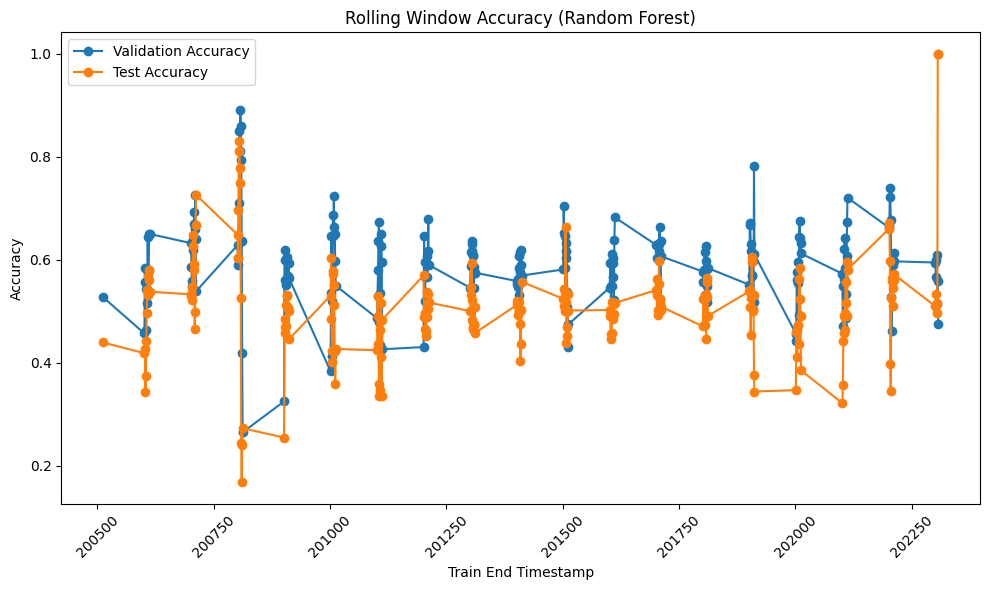

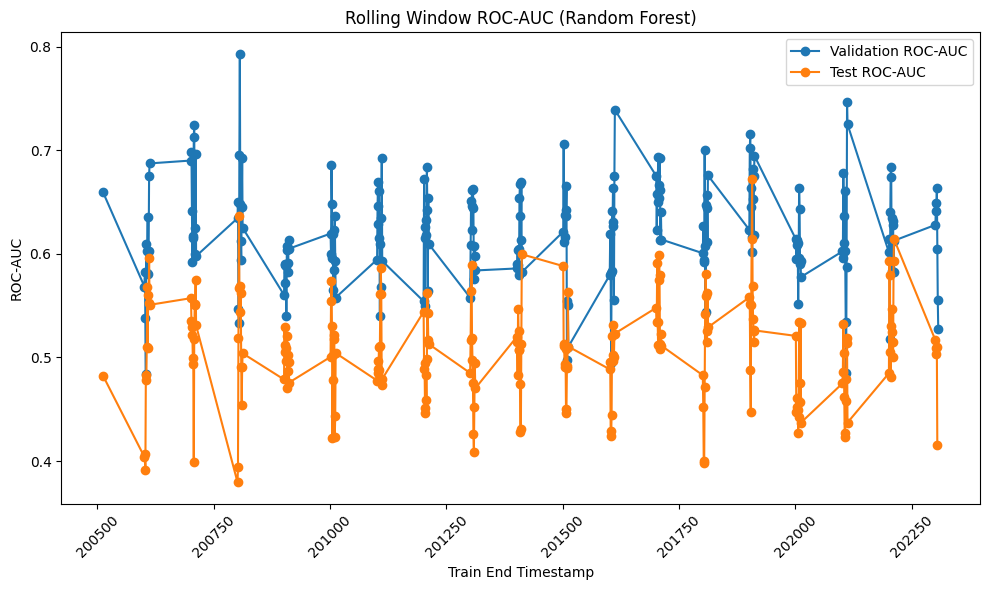

Summary of Feature Importances Across Rolling Windows:
           train_end          PS          PB         EVM  PCA_Valuation_PE_1  \
count     212.000000  212.000000  212.000000  212.000000          212.000000   
mean   201431.915094    0.104084    0.100886    0.052781            0.095649   
std       511.776927    0.005189    0.007327    0.014895            0.004927   
min    200512.000000    0.095338    0.087534    0.027583            0.083675   
25%    201004.750000    0.100198    0.093686    0.043895            0.093055   
50%    201409.500000    0.103459    0.103401    0.052323            0.095316   
75%    201902.250000    0.106268    0.107382    0.058335            0.097423   
max    202307.000000    0.121801    0.112475    0.100527            0.110646   

       PCA_Valuation_PE_2  PCA_Profitability_1  PCA_Leverage_1  \
count          212.000000           212.000000      212.000000   
mean             0.097497             0.095759        0.093844   
std              0.006695 

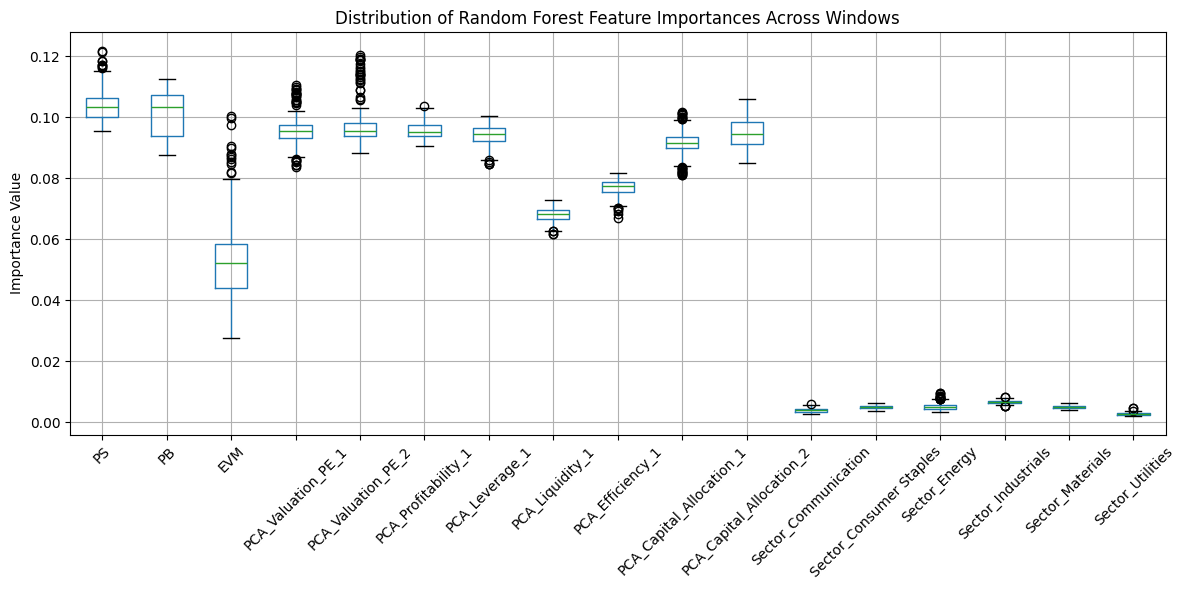

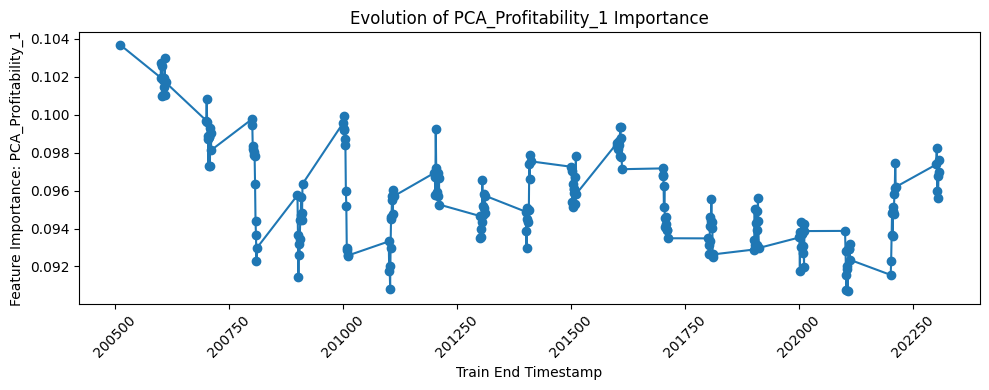

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# 1. Aggregate Rolling Window Performance Metrics into a DataFrame
# =============================================================================
metrics_rf = pd.DataFrame([{
    "train_end": res["train_end"],
    "val_acc": res["val_acc"],
    "test_acc": res["test_acc"],
    "val_roc_auc": res["val_roc_auc"],
    "test_roc_auc": res["test_roc_auc"]
} for res in results_rf])

print("Rolling Window Random Forest Performance Metrics Summary:")
print(metrics_rf.describe())

# =============================================================================
# 2. Plot Performance Metrics Over Time
# =============================================================================
plt.figure(figsize=(10, 6))
plt.plot(metrics_rf["train_end"], metrics_rf["val_acc"], marker="o", label="Validation Accuracy")
plt.plot(metrics_rf["train_end"], metrics_rf["test_acc"], marker="o", label="Test Accuracy")
plt.xlabel("Train End Timestamp")
plt.ylabel("Accuracy")
plt.title("Rolling Window Accuracy (Random Forest)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(metrics_rf["train_end"], metrics_rf["val_roc_auc"], marker="o", label="Validation ROC-AUC")
plt.plot(metrics_rf["train_end"], metrics_rf["test_roc_auc"], marker="o", label="Test ROC-AUC")
plt.xlabel("Train End Timestamp")
plt.ylabel("ROC-AUC")
plt.title("Rolling Window ROC-AUC (Random Forest)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =============================================================================
# 3. Summarize Model Feature Importances Across Rolling Windows
# =============================================================================
# Create a list to hold feature importances along with the corresponding train_end timestamp.
importance_list = []
for res in results_rf:
    rf_model = res["model"]
    imp = rf_model.feature_importances_
    imp_dict = {"train_end": res["train_end"]}
    # Assume that x_vars is a list of predictor names (and in same order as model input).
    for idx, feature in enumerate(x_vars):
        imp_dict[feature] = imp[idx]
    importance_list.append(imp_dict)

importance_df = pd.DataFrame(importance_list)

print("Summary of Feature Importances Across Rolling Windows:")
print(importance_df.describe())

# Plot boxplots for each predictor's importance
plt.figure(figsize=(12, 6))
importance_df.boxplot(column=x_vars, rot=45)
plt.title("Distribution of Random Forest Feature Importances Across Windows")
plt.ylabel("Importance Value")
plt.tight_layout()
plt.show()

# Optionally, you can also plot the evolution of one or two key feature importances over time.
# For example, to track 'PCA_Profitability_1':
plt.figure(figsize=(10, 4))
plt.plot(importance_df["train_end"], importance_df["PCA_Profitability_1"], marker="o", linestyle="-")
plt.xlabel("Train End Timestamp")
plt.ylabel("Feature Importance: PCA_Profitability_1")
plt.title("Evolution of PCA_Profitability_1 Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Original sample_data shape: (829, 17)
Contiguous sample_data_np shape: (829, 17)


 99%|===================| 1647/1658 [01:27<00:00]       

SHAP values shape: (829, 17, 2)


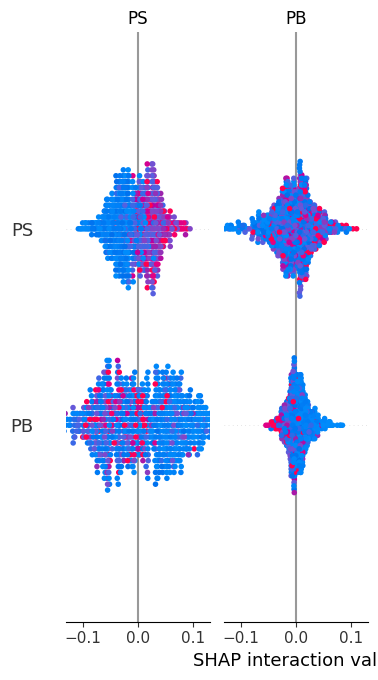

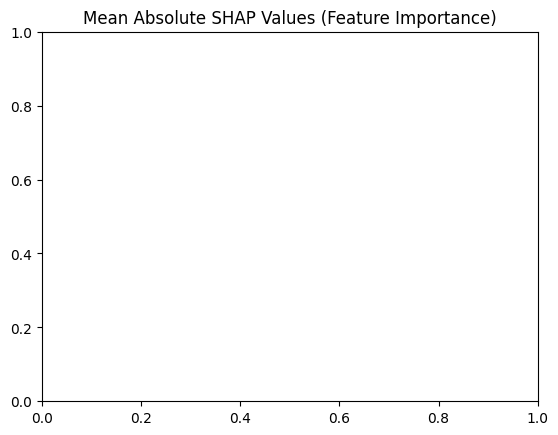

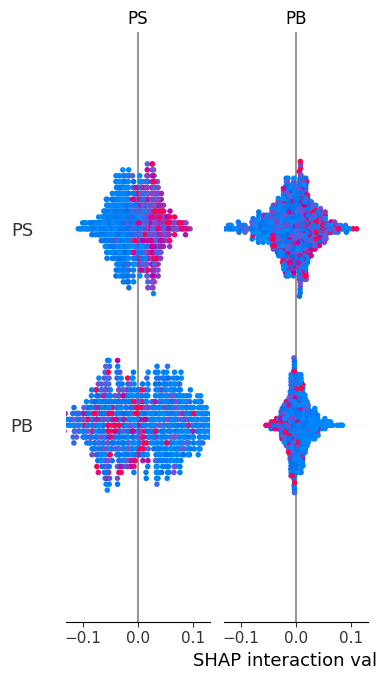

Text(0.5, 1.0, 'SHAP Summary Plot for Random Forest Model')

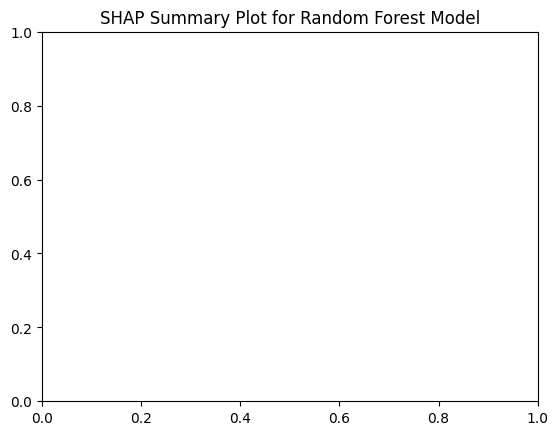

In [19]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Select the final Random Forest model from your rolling-window results
final_rf_model = results_rf[-1]["model"]

# Use the validation set from the final window as a sample for SHAP analysis.
# Make sure to select only the predictor columns (x_vars)
sample_data = results_rf[-1]["validation_data"][x_vars].copy()
print("Original sample_data shape:", sample_data.shape)

# Convert the DataFrame to a contiguous NumPy array in C-order
sample_data_np = np.ascontiguousarray(sample_data.values)
print("Contiguous sample_data_np shape:", sample_data_np.shape)

# Create a SHAP TreeExplainer for the Random Forest model
explainer = shap.TreeExplainer(final_rf_model, sample_data_np)

# Compute SHAP values for the sample_data, disabling the additivity check at call time.
shap_values = explainer(sample_data_np, check_additivity=False)

# Debug: Print the shape of the SHAP values.
# We expect shap_values.values to have shape (829, 17)
print("SHAP values shape:", shap_values.values.shape)

# Generate a bar summary plot of the mean absolute SHAP values.
shap.summary_plot(shap_values.values, sample_data, plot_type="bar")
plt.title("Mean Absolute SHAP Values (Feature Importance)")

# Generate a beeswarm summary plot.
shap.summary_plot(shap_values.values, sample_data)
plt.title("SHAP Summary Plot for Random Forest Model")


Original sample_data shape: (829, 17)
Contiguous sample_data_np shape: (829, 17)


100%|===================| 1653/1658 [01:26<00:00]       

Original SHAP values shape: (829, 17, 2)
SHAP values for class 1 shape: (829, 17)


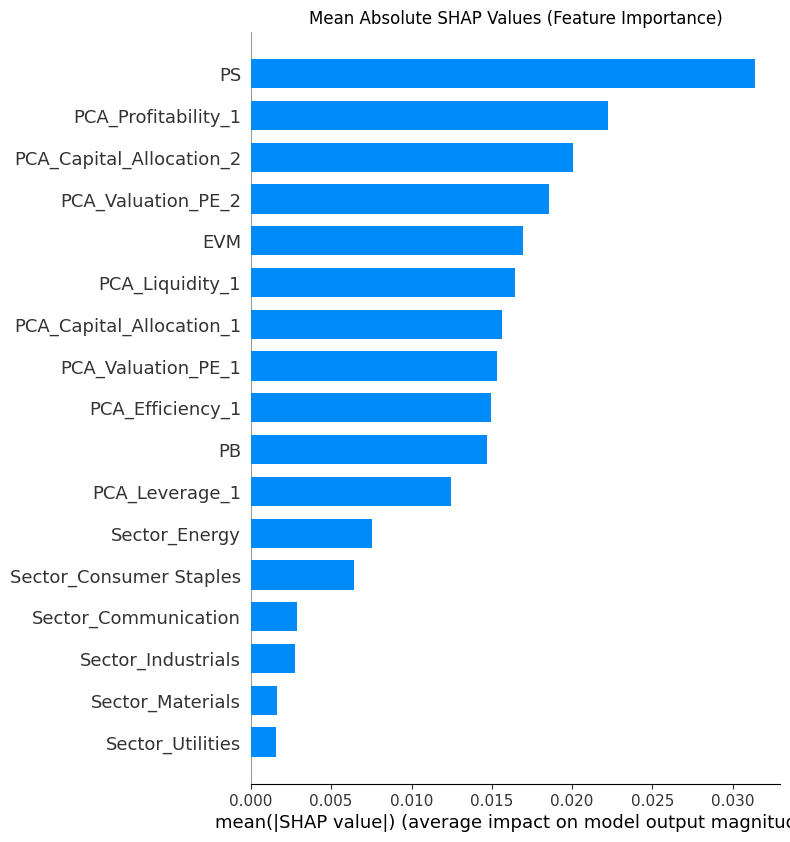

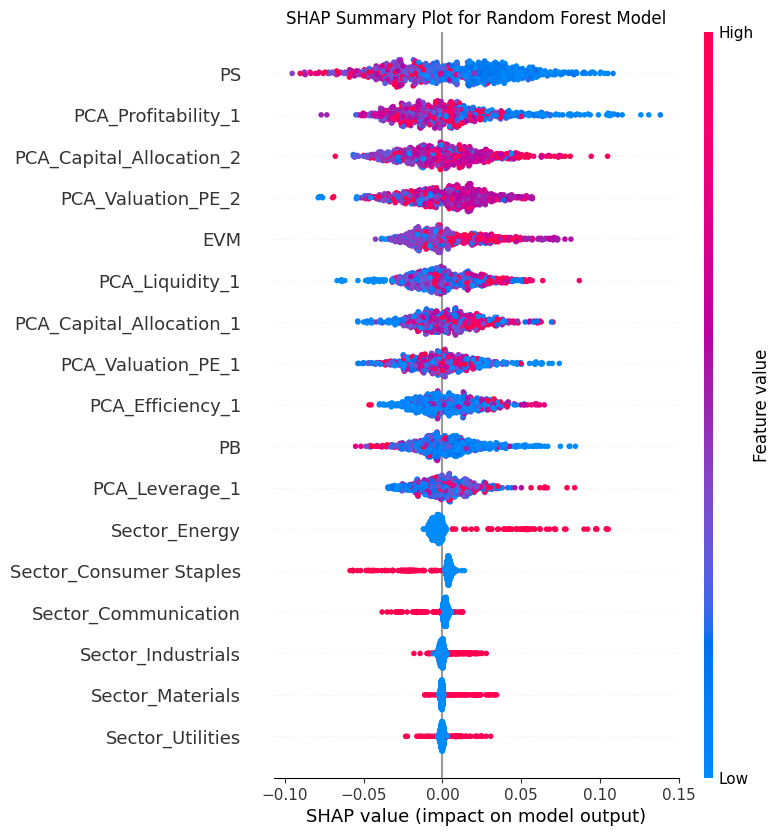

In [20]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Select the final Random Forest model from your rolling-window results
final_rf_model = results_rf[-1]["model"]

# Use the validation set from the final window as a sample for SHAP analysis.
# Select only the predictor columns (x_vars)
sample_data = results_rf[-1]["validation_data"][x_vars].copy()
print("Original sample_data shape:", sample_data.shape)

# Convert the DataFrame to a contiguous NumPy array in C-order
sample_data_np = np.ascontiguousarray(sample_data.values)
print("Contiguous sample_data_np shape:", sample_data_np.shape)

# Create a SHAP TreeExplainer for the Random Forest model
explainer = shap.TreeExplainer(final_rf_model, sample_data_np)

# Compute SHAP values for the sample_data, disabling additivity check at call time.
shap_values = explainer(sample_data_np, check_additivity=False)

# Debug: Print the shape of the returned SHAP values.
# For a binary classifier, the new SHAP API returns a 3D array of shape
# (n_samples, n_features, n_outputs). We extract the values for class 1.
print("Original SHAP values shape:", shap_values.values.shape)

# Extract class 1 SHAP values (assuming index 1 corresponds to class 1)
shap_values_class1 = shap_values.values[:, :, 1]
print("SHAP values for class 1 shape:", shap_values_class1.shape)

# -----------------------------------------------------------------------------
# Generate a bar summary plot of the mean absolute SHAP values for class 1
# -----------------------------------------------------------------------------
shap.summary_plot(shap_values_class1, sample_data, plot_type="bar", show=False)
plt.title("Mean Absolute SHAP Values (Feature Importance)")
plt.show()

# -----------------------------------------------------------------------------
# Generate a beeswarm summary plot for class 1
# -----------------------------------------------------------------------------
shap.summary_plot(shap_values_class1, sample_data, show=False)
plt.title("SHAP Summary Plot for Random Forest Model")
plt.show()


In [21]:
import pandas as pd
import numpy as np

# Compute the mean absolute SHAP value for each feature (across all 829 samples)
mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)

# Compute the standard deviation of the absolute SHAP values for each feature
std_abs_shap = np.abs(shap_values_class1).std(axis=0)

# Create a DataFrame for easy viewing
shap_summary_df = pd.DataFrame({
    "Feature": x_vars,
    "Mean_Absolute_SHAP": mean_abs_shap,
    "Std_Absolute_SHAP": std_abs_shap
})

# Sort the DataFrame by mean absolute SHAP value in descending order
shap_summary_df = shap_summary_df.sort_values(by="Mean_Absolute_SHAP", ascending=False)

print("SHAP Summary Statistics:")
print(shap_summary_df)


SHAP Summary Statistics:
                     Feature  Mean_Absolute_SHAP  Std_Absolute_SHAP
0                         PS            0.031369           0.021130
5        PCA_Profitability_1            0.022246           0.020548
10  PCA_Capital_Allocation_2            0.020055           0.015747
4         PCA_Valuation_PE_2            0.018582           0.013603
2                        EVM            0.016911           0.014524
7            PCA_Liquidity_1            0.016455           0.013504
9   PCA_Capital_Allocation_1            0.015610           0.012502
3         PCA_Valuation_PE_1            0.015327           0.012708
8           PCA_Efficiency_1            0.014939           0.011349
1                         PB            0.014699           0.013192
6             PCA_Leverage_1            0.012441           0.010654
13             Sector_Energy            0.007551           0.015002
12   Sector_Consumer Staples            0.006391           0.007855
11      Sector_Communic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b51aa3c8a40843c88a4dba070800abfdcf434538a36eccebf910ad197c721bfb
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
Validation sample_data shape: (829, 17)
Intercept 0.5071226022722837
Prediction_local [0.52930108]
Right: 0.39
LIME Explanation Weights (for instance index 0):
PS <= -0.85: 0.0383
PCA_Profitability_1 <= -0.50: 0.0382
Sector_Energy <= 0.00: -0.0268
EVM <= 0.30: -0.0243
PB <= -0.25: 0.0241
PCA_Capital_Allocation_2 <= -0.26: -0.0165
Sector_Utilities <= 0.00: -0.0128
0.37 < PCA_Valuation_PE_2 <= 0.90: 0.0127
Sector_Consumer Staples <= 0.00: 0.0122
-0.74 < PCA_Capital_Allocation_1 <= -0.02: -0.0117
0.08 < PCA_Liquidity_1 <= 0.70: -0.0093
Sector_Materials <= 0.00: -0.0091
PCA_Efficiency_1 > 0.71:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


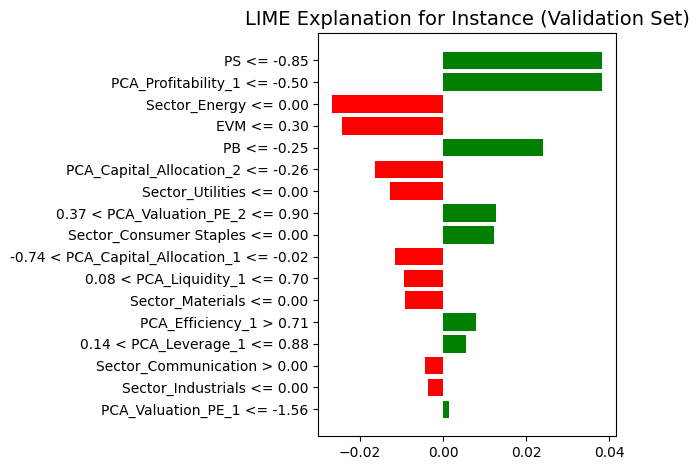

In [22]:
# Install LIME if not already installed
!pip install lime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

# Select the final Random Forest model from your rolling-window results
final_rf_model = results_rf[-1]["model"]

# Use the validation set from the final window for LIME analysis.
# We assume that x_vars is defined and that the validation data contains only predictor columns.
sample_data = results_rf[-1]["validation_data"][x_vars].copy()
print("Validation sample_data shape:", sample_data.shape)

# For LIME, we need a background dataset.
# Here, we use a random sample (or all) of the validation data.
background_data = sample_data.values  # Use all validation data as background

# Define a prediction function that returns probabilities for class 1.
def predict_fn(data):
    # data is a 2D numpy array
    return final_rf_model.predict_proba(data)

# Create a LimeTabularExplainer.
# We use the background data, feature names, and set the training labels as categorical.
explainer = LimeTabularExplainer(background_data,
                                 feature_names=x_vars,
                                 class_names=["Class 0", "Class 1"],
                                 mode='classification',
                                 discretize_continuous=True,
                                 verbose=True)

# Choose an instance from the validation set to explain.
# For example, choose instance at index 0.
instance_idx = 0
instance = sample_data.iloc[instance_idx].values

# Generate LIME explanation for the chosen instance.
explanation = explainer.explain_instance(instance, predict_fn, num_features=len(x_vars))

# Print LIME explanation weights.
lime_weights = explanation.as_list()
print("LIME Explanation Weights (for instance index {}):".format(instance_idx))
for feature, weight in lime_weights:
    print(f"{feature}: {weight:.4f}")

# Plot the explanation.
# We'll customize the figure for a white background.
fig = explanation.as_pyplot_figure()
fig.set_facecolor("white")
plt.title("LIME Explanation for Instance (Validation Set)", fontsize=14)
plt.tight_layout()
plt.show()
